In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss)
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    original_loss = focal_loss(student_outputs[:,0,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            #loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0514_Focal_Loss_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 9s 731ms/step - loss: 0.0940
Average validation loss: 0.157335102558136
4/4 [==============================] - 9s 751ms/step - loss: 0.0940 - val_loss: 0.1573
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 12s 724ms/step - loss: 0.0712 - val_loss: 0.1573
Average validation loss: 0.17025041580200195
4/4 [==============================] - 12s 742ms/step - loss: 0.0712 - val_loss: 0.1638
Epoch 3/10
4/4 [==============================] - 15s 704ms/step - loss: 0.0553 - val_loss: 0.1638
Average validation loss: 0.19792485237121582
4/4 [==============================] - 15s 725ms/step - loss: 0.0553 - val_loss: 0.1752
Epoch 4/10
4/4 [==============================] - 18s 705ms/step - loss: 0.0442 - val_loss: 0.1752
Average validation loss: 0.25977858901023865
4/4 [==============================] - 18s 725ms

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 734ms/step - loss: 0.0027
Average validation loss: 0.2122134566307068
8/8 [==============================] - 6s 748ms/step - loss: 0.0027 - val_loss: 0.2122
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 12s 734ms/step - loss: 0.0058 - val_loss: 0.2122
Average validation loss: 0.37688660621643066
8/8 [==============================] - 12s 749ms/step - loss: 0.0058 - val_loss: 0.2946
Epoch 3/10
8/8 [==============================] - 18s 735ms/step - loss: 0.0048 - val_loss: 0.2946
Average validation loss: 0.22329668700695038
8/8 [==============================] - 18s 749ms/step - loss: 0.0048 - val_loss: 0.2708
Epoch 4/10
8/8 [==============================] - 24s 730ms/step - loss: 0.0043 - val_loss: 0.2708
Average validation loss: 0.2613770216703415
8/8 [==============================] - 24s 744m

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 701ms/step - loss: 0.0034
Average validation loss: 0.2647360935807228
12/12 [==============================] - 9s 712ms/step - loss: 0.0034 - val_loss: 0.2647
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 691ms/step - loss: 0.0032 - val_loss: 0.2647
Average validation loss: 1.2886950174967449
12/12 [==============================] - 17s 702ms/step - loss: 0.0032 - val_loss: 0.7767
Epoch 3/10
12/12 [==============================] - 26s 692ms/step - loss: 0.0031 - val_loss: 0.7767
Average validation loss: 0.381480077902476
12/12 [==============================] - 26s 704ms/step - loss: 0.0031 - val_loss: 0.6450
Epoch 4/10
12/12 [==============================] - 34s 693ms/step - loss: 0.0031 - val_loss: 0.6450
Average validation loss: 0.20190973579883575
12/12 [============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 707ms/step - loss: 0.0030
Average validation loss: 0.36378971487283707
16/16 [==============================] - 12s 720ms/step - loss: 0.0030 - val_loss: 0.3638
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 686ms/step - loss: 0.0028 - val_loss: 0.3638
Average validation loss: 0.10558852180838585
16/16 [==============================] - 23s 699ms/step - loss: 0.0028 - val_loss: 0.2347
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_20.pth'.
Epoch 3/10
16/16 [==============================] - 34s 684ms/step - loss: 0.0027 - val_loss: 0.2347
Average validation loss: 0.13108403235673904
16/16 [==============================] - 34s 696ms/step - loss: 0.0027 - val_loss: 0.2002
Epoch 4/10
16/16 [==========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 713ms/step - loss: 0.0018
Average validation loss: 0.1734551429748535
20/20 [==============================] - 15s 726ms/step - loss: 0.0018 - val_loss: 0.1735
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 704ms/step - loss: 0.0017 - val_loss: 0.1735
Average validation loss: 0.21621857285499574
20/20 [==============================] - 29s 715ms/step - loss: 0.0017 - val_loss: 0.1948
Epoch 3/10
20/20 [==============================] - 43s 717ms/step - loss: 0.0017 - val_loss: 0.1948
Average validation loss: 0.16867925226688385
20/20 [==============================] - 44s 729ms/step - loss: 0.0017 - val_loss: 0.1861
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_25.pth'.
Epoch 4/10
20/20 [===========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 723ms/step - loss: 0.0019
Average validation loss: 0.13799109061559042
24/24 [==============================] - 18s 734ms/step - loss: 0.0019 - val_loss: 0.1380
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 715ms/step - loss: 0.0017 - val_loss: 0.1380
Average validation loss: 0.1520560880502065
24/24 [==============================] - 35s 726ms/step - loss: 0.0017 - val_loss: 0.1450
Epoch 3/10
24/24 [==============================] - 52s 709ms/step - loss: 0.0017 - val_loss: 0.1450
Average validation loss: 0.2035088191429774
24/24 [==============================] - 52s 721ms/step - loss: 0.0017 - val_loss: 0.1645
Epoch 4/10
24/24 [==============================] - 69s 704ms/step - loss: 0.0016 - val_loss: 0.1645
Average validation loss: 0.18403982867797217
24/24 [========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 30s 750ms/step - loss: 0.0023
Average validation loss: 0.2036268949508667
40/40 [==============================] - 30s 762ms/step - loss: 0.0023 - val_loss: 0.2036
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 719ms/step - loss: 0.0021 - val_loss: 0.2036
Average validation loss: 0.19115255177021026
40/40 [==============================] - 60s 732ms/step - loss: 0.0021 - val_loss: 0.1974
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 88s 703ms/step - loss: 0.0019 - val_loss: 0.1974
Average validation loss: 0.18388760536909105
40/40 [==============================] - 89s 716ms/step - loss: 0.0019 - val_loss: 0.1929
Saved model weights to 'c:\Us

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 719ms/step - loss: 0.0017
Average validation loss: 0.23133900264898935
48/48 [==============================] - 35s 730ms/step - loss: 0.0017 - val_loss: 0.2313
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 70s 732ms/step - loss: 0.0015 - val_loss: 0.2313
Average validation loss: 0.19648249571522078
48/48 [==============================] - 71s 743ms/step - loss: 0.0015 - val_loss: 0.2139
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 106s 727ms/step - loss: 0.0014 - val_loss: 0.2139
Average validation loss: 0.20642237116893133
48/48 [==============================] - 106s 739ms/step - loss: 0.0014 - val_loss: 0.2114
Epoch 4/10
48/48 [========

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 723ms/step - loss: 0.0015
Average validation loss: 0.214958379311221
56/56 [==============================] - 41s 735ms/step - loss: 0.0015 - val_loss: 0.2150
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 719ms/step - loss: 0.0013 - val_loss: 0.2150
Average validation loss: 0.20428713943277085
56/56 [==============================] - 82s 731ms/step - loss: 0.0013 - val_loss: 0.2096
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 123s 724ms/step - loss: 0.0012 - val_loss: 0.2096
Average validation loss: 0.1958601102232933
56/56 [==============================] - 123s 735ms/step - loss: 0.0012 - val_loss: 0.2050
Saved model weights to 'c:\Us

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 717ms/step - loss: 0.0012
Average validation loss: 0.19609064888209105
64/64 [==============================] - 47s 729ms/step - loss: 0.0012 - val_loss: 0.1961
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 721ms/step - loss: 0.0010 - val_loss: 0.1961
Average validation loss: 0.18403148278594017
64/64 [==============================] - 94s 733ms/step - loss: 0.0010 - val_loss: 0.1901
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 724ms/step - loss: 9.4496e-04 - val_loss: 0.1901
Average validation loss: 0.19822861347347498
64/64 [==============================] - 141s 736ms/step - loss: 9.4496e-04 - val_loss: 0.1928
Epoch 4/10
64/64 [

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 52s 717ms/step - loss: 0.0011
Average validation loss: 0.19473506261905035
72/72 [==============================] - 52s 728ms/step - loss: 0.0011 - val_loss: 0.1947
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 104s 720ms/step - loss: 9.5252e-04 - val_loss: 0.1947
Average validation loss: 0.18351870940791237
72/72 [==============================] - 105s 731ms/step - loss: 9.5252e-04 - val_loss: 0.1891
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 157s 717ms/step - loss: 8.5139e-04 - val_loss: 0.1891
Average validation loss: 0.18279414044486153
72/72 [==============================] - 158s 728ms/step - loss: 8.5139e-04 - val_loss: 0.1870
Saved mo

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 58s 719ms/step - loss: 0.0011
Average validation loss: 0.1981012314558029
80/80 [==============================] - 59s 731ms/step - loss: 0.0011 - val_loss: 0.1981
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 115s 709ms/step - loss: 9.1962e-04 - val_loss: 0.1981
Average validation loss: 0.17940233051776885
80/80 [==============================] - 116s 720ms/step - loss: 9.1962e-04 - val_loss: 0.1888
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 173s 708ms/step - loss: 8.1655e-04 - val_loss: 0.1888
Average validation loss: 0.20194824263453484
80/80 [==============================] - 174s 719ms/step - loss: 8.1655e-04 - val_loss: 0.1932
Epoch 4

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 711ms/step - loss: 0.0014
Average validation loss: 0.19823318098982176
96/96 [==============================] - 69s 722ms/step - loss: 0.0014 - val_loss: 0.1982
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 137s 708ms/step - loss: 0.0012 - val_loss: 0.1982
Average validation loss: 0.19736933087309202
96/96 [==============================] - 138s 719ms/step - loss: 0.0012 - val_loss: 0.1978
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 206s 701ms/step - loss: 0.0010 - val_loss: 0.1978
Average validation loss: 0.18124937204023203
96/96 [==============================] - 207s 712ms/step - loss: 0.0010 - val_loss: 0.1923
Saved model weights to

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 707ms/step - loss: 0.0012
Average validation loss: 0.19012092699607214
120/120 [==============================] - 86s 718ms/step - loss: 0.0012 - val_loss: 0.1901
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 706ms/step - loss: 9.2840e-04 - val_loss: 0.1901
Average validation loss: 0.18664271732171375
120/120 [==============================] - 172s 717ms/step - loss: 9.2840e-04 - val_loss: 0.1884
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 705ms/step - loss: 8.3336e-04 - val_loss: 0.1884
Average validation loss: 0.17722979187965393
120/120 [==============================] - 258s 716ms/step - loss: 8.3336e-04 - val_loss: 0

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 103s 716ms/step - loss: 0.0010
Average validation loss: 0.18455901079707676
144/144 [==============================] - 105s 727ms/step - loss: 0.0010 - val_loss: 0.1846
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 208s 717ms/step - loss: 8.1840e-04 - val_loss: 0.1846
Average validation loss: 0.18772674393322733
144/144 [==============================] - 210s 728ms/step - loss: 8.1840e-04 - val_loss: 0.1861
Epoch 3/10
144/144 [==============================] - 313s 714ms/step - loss: 7.0801e-04 - val_loss: 0.1861
Average validation loss: 0.19098680011100239
144/144 [==============================] - 314s 725ms/step - loss: 7.0801e-04 - val_loss: 0.1878
Epoch 4/10
144/144 [==============================] - 416s 708ms/step - loss: 6.2783e-04 - val_loss: 0.1878
Average validation loss: 0.18411

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 704ms/step - loss: 6.4566e-04
Average validation loss: 0.18424119614064693
160/160 [==============================] - 114s 715ms/step - loss: 6.4566e-04 - val_loss: 0.1842
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 706ms/step - loss: 6.0862e-04 - val_loss: 0.1842
Average validation loss: 0.1905480120331049
160/160 [==============================] - 229s 717ms/step - loss: 6.0862e-04 - val_loss: 0.1874
Epoch 3/10
160/160 [==============================] - 343s 709ms/step - loss: 5.8296e-04 - val_loss: 0.1874
Average validation loss: 0.1899021953344345
160/160 [==============================] - 344s 720ms/step - loss: 5.8296e-04 - val_loss: 0.1882
Epoch 4/10
160/160 [==============================] - 457s 706ms/step - loss: 5.7028e-04 - val_loss: 0.1882
Average validation loss: 0

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 715ms/step - loss: 0.0012
Average validation loss: 0.18202393084764482
200/200 [==============================] - 145s 726ms/step - loss: 0.0012 - val_loss: 0.1820
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 287s 706ms/step - loss: 0.0010 - val_loss: 0.1820
Average validation loss: 0.17354318022727966
200/200 [==============================] - 289s 717ms/step - loss: 0.0010 - val_loss: 0.1778
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 429s 700ms/step - loss: 9.0722e-04 - val_loss: 0.1778
Average validation loss: 0.17240991830825805
200/200 [==============================] - 431s 711ms/step - loss: 9.0722e-04 - val_loss: 0.1760


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 3:16 - loss: 0.0012

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 718ms/step - loss: 0.0011
Average validation loss: 0.17718295902013778
240/240 [==============================] - 175s 729ms/step - loss: 0.0011 - val_loss: 0.1772
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 344s 705ms/step - loss: 9.3045e-04 - val_loss: 0.1772
Average validation loss: 0.16704977477590244
240/240 [==============================] - 347s 716ms/step - loss: 9.3045e-04 - val_loss: 0.1721
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0514_Focal_Loss_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 517s 706ms/step - loss: 8.3957e-04 - val_loss: 0.1721
Average validation loss: 0.16929102192322412
240/240 [==============================] - 519s 717ms/step - loss: 8.3957e-04 - val_loss:

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.4710222126170993, 0.36080937057733536, 0.3005143248289823, 0.27997459307312966, 0.2464908384084702, 0.2148307418823242, 0.19878879028558727, 0.20086019804080327, 0.20411657395107408, 0.19929798400029541, 0.2027882868713803, 0.19772253054380418, 0.19428730734934413, 0.19387144915262863, 0.18492576327588825, 0.18250944937765604, 0.17935930939912798, 0.17446852306524913]
std_val_losses =  [0.41945201833223, 0.3019192396651965, 0.20427982705275508, 0.1804243040408441, 0.0815188836849355, 0.031572881310348896, 0.021042012014213823, 0.016995751229425576, 0.014880823786830923, 0.015291586766117785, 0.019381600239365367, 0.0178538050695123, 0.015513354624183174, 0.010094349559403795, 0.012691171942708985, 0.008810605214716077, 0.007896839433103974, 0.008451036136421744]


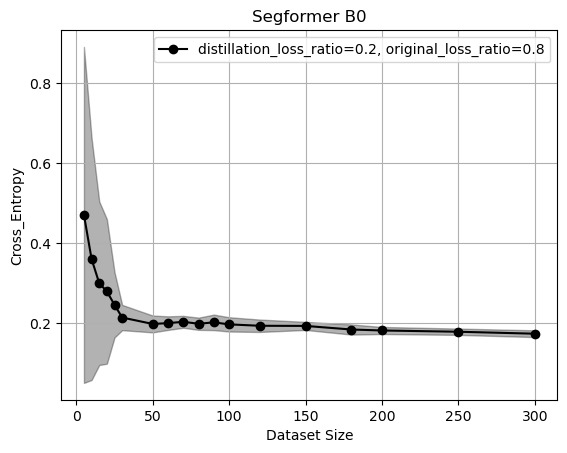

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()